Epoch 1/10, Loss: 0.27617733069957245
Epoch 2/10, Loss: 0.24466048012015837
Epoch 3/10, Loss: 0.23765947788459765
Epoch 4/10, Loss: 0.23461154495804062
Epoch 5/10, Loss: 0.23222941300845598
Epoch 6/10, Loss: 0.23044566111786172
Epoch 7/10, Loss: 0.22899331508668952
Epoch 8/10, Loss: 0.22772744636567638
Epoch 9/10, Loss: 0.22656261482531012
Epoch 10/10, Loss: 0.2254413810277582
Test accuracy: 0.9055837563451776
Total: 17730


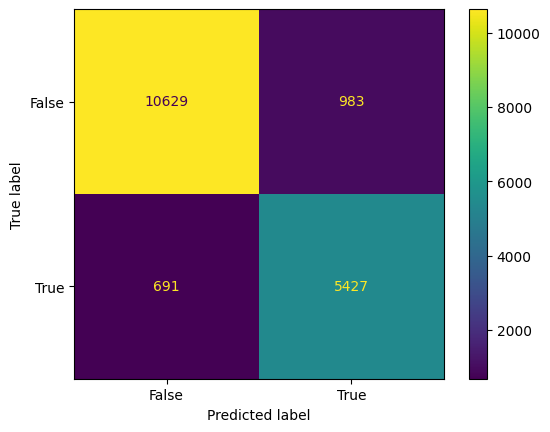

Precision: 0.8466458658346334
Recall: 0.8870545930042497
F1 Score: 0.8663793103448275


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

DATA_STORED = "trimmed_data.npy"

# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from src.NeuralNetwork import NeuralNetwork

data_array = np.load(DATA_STORED)

if data_array.shape[0] == 21:
    data_array = data_array.T

# Assuming numpy array has the shape (num_datapoints, 21)
# The last column is the label, and the first 20 columns are the features
features = data_array[:,:-1]
labels = data_array[:,-1]

# Convert to PyTorch tensors
features = torch.tensor(features, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.float32)

# Split the data into training and testing sets
features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, test_size=0.2, random_state=42)

# Create DataLoader for training and testing data
batch_size = 32
train_dataset = TensorDataset(features_train, labels_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(features_test, labels_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Hyperparameters
input_size = 20
hidden_size = 24
output_size = 1
num_hidden_layers = 5
learning_rate = 0.001
num_epochs = 10

# Instantiate the model, move it to the GPU
model = NeuralNetwork(input_size, hidden_size, output_size, num_hidden_layers).to(device)


criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# trainig
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0

    for batch_features, batch_labels in train_loader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        # Forward pass
        outputs = model(batch_features)
        loss = criterion(outputs.view(-1), batch_labels)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_loader)}")

# Test set eval
model.eval()
all_predictions = []
all_labels = []
with torch.no_grad():
    correct = 0
    total = 0

    for batch_features, batch_labels in test_loader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
        outputs = model(batch_features)
        predicted = (torch.sigmoid(outputs) >= 0.5).float()
        total += batch_labels.size(0)
        correct += (predicted.view(-1) == batch_labels).sum().item()
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())

    #print("test dataset shape ", str(test_dataset.shape))
    accuracy = correct / total
    print("Test accuracy:", accuracy)
    print("Total:", total)
    all_predictions = np.array(all_predictions).flatten()
    all_labels = np.array(all_labels)

    # Compute metrics
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    confusion_matrix = confusion_matrix(all_labels, all_predictions) 
    cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True]) 
    cm_display.plot()
    plt.show() 

    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)



# Load the saved model
# model = NeuralNetwork(input_size, hidden_size, output_size, num_hidden_layers).to(device)
# model.load_state_dict(torch.load(model_path))
# model.eval()


In [4]:
save_input = input("Save file? (y/n)")
while save_input != "y" and save_input != "n":
    save_input = input("Save file? (y/n)")
if save_input == "y":
    print("File will be saved under 'trained_weights' folder")
    model_path = input("Filename to save (****.pth) ")
    if model_path == "":
        model_path = '{}_{}_{}_{}.pth'.format(str(learning_rate),str(num_epochs),str(num_hidden_layers),str(hidden_size))
    else:
        model_path = '{}_{}_{}_{}_{}.pth'.format(model_path,str(learning_rate),str(num_epochs),str(num_hidden_layers),str(hidden_size))
    save_path = '{}/{}'.format("trained_weights/neural", model_path)
    torch.save(model.state_dict(), save_path)
    print("Model saved successfully at:", save_path)

File will be saved under 'trained_weights' folder
Model saved successfully at: trained_weights/neural/kindagood_0.001_10_5_24.pth
